# ============================================
# NOTEBOOK: 02_modelado.ipynb
# OBJETIVO: Entrenar modelo XGBoost para clasificación de riesgo crediticio
# AUTOR: [Tu nombre]
# FECHA: [Fecha actual]
# ============================================

# # 🤖 Modelado con XGBoost
# 
# ## Objetivo
# Entrenar un modelo de clasificación binaria para predecir riesgo crediticio
# 
# ## Contenido
# 1. Carga de datos y preprocesamiento
# 2. Split train/test
# 3. Encoding de variables categóricas
# 4. Entrenamiento XGBoost baseline
# 5. Evaluación con múltiples métricas
# 6. Guardar modelo
# 7. Análisis de feature importance

In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Guardar modelos
import joblib
from pathlib import Path

# Configuración
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


In [4]:
# Cargar datos de german_credit_data

# Nombres de las columnas
column_names = [
    'checking_status', 'duration', 'credit_history', 'purpose', 
    'credit_amount', 'savings_status', 'employment', 'installment_rate',
    'personal_status', 'other_parties', 'residence_since', 
    'property_magnitude', 'age', 'other_payment_plans', 'housing',
    'existing_credits', 'job', 'num_dependents', 'own_telephone',
    'foreign_worker', 'risk'
]

# Cargar dataset
df = pd.read_csv('../../german_credit_data/german.data', 
                 sep=' ',
                 header=None,
                 names=column_names)

# Convertir target: 1=Good, 2=Bad → 0=Good, 1=Bad
df['risk'] = df['risk'].map({1: 0, 2: 1})

print("✅ Datos cargados correctamente")
print(f"📊 Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
print(f"🎯 Target: {df['risk'].value_counts().to_dict()}")


✅ Datos cargados correctamente
📊 Dimensiones: 1000 filas x 21 columnas
🎯 Target: {0: 700, 1: 300}


# ## 2. Preprocesamiento de Datos

In [6]:
# Separar features y target
X = df.drop('risk', axis=1)
y = df['risk']

print("="*60)
print("SEPARACIÓN FEATURES Y TARGET")
print("="*60)
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nDistribución del target:")
print(y.value_counts())
print(f"Proporción: {y.value_counts(normalize=True).to_dict()}")

SEPARACIÓN FEATURES Y TARGET
Features (X): (1000, 20)
Target (y): (1000,)

Distribución del target:
risk
0    700
1    300
Name: count, dtype: int64
Proporción: {0: 0.7, 1: 0.3}


In [7]:
# Identificar tipos de variables
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("="*60)
print("TIPOS DE VARIABLES")
print("="*60)
print(f"\n📊 Variables Numéricas ({len(numeric_features)}):")
for col in numeric_features:
    print(f"  - {col}")

print(f"\n📝 Variables Categóricas ({len(categorical_features)}):")
for col in categorical_features:
    unique_count = X[col].nunique()
    print(f"  - {col} ({unique_count} categorías únicas)")

TIPOS DE VARIABLES

📊 Variables Numéricas (7):
  - duration
  - credit_amount
  - installment_rate
  - residence_since
  - age
  - existing_credits
  - num_dependents

📝 Variables Categóricas (13):
  - checking_status (4 categorías únicas)
  - credit_history (5 categorías únicas)
  - purpose (10 categorías únicas)
  - savings_status (5 categorías únicas)
  - employment (5 categorías únicas)
  - personal_status (4 categorías únicas)
  - other_parties (3 categorías únicas)
  - property_magnitude (4 categorías únicas)
  - other_payment_plans (3 categorías únicas)
  - housing (3 categorías únicas)
  - job (4 categorías únicas)
  - own_telephone (2 categorías únicas)
  - foreign_worker (2 categorías únicas)


# ## 3. Encoding de Variables Categóricas

In [8]:
# Crear copia para no modificar original
X_encoded = X.copy()

# Aplicar Label Encoding a todas las categóricas
# Nota: Para XGBoost, Label Encoding es suficiente y eficiente
# (XGBoost puede manejar variables categóricas codificadas numéricamente)

label_encoders = {}

print("="*60)
print("ENCODING DE VARIABLES CATEGÓRICAS")
print("="*60)

for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    
    print(f"✅ {col}: {X[col].nunique()} categorías → 0 a {X_encoded[col].max()}")

print(f"\n✅ Total de encoders guardados: {len(label_encoders)}")

ENCODING DE VARIABLES CATEGÓRICAS
✅ checking_status: 4 categorías → 0 a 3
✅ credit_history: 5 categorías → 0 a 4
✅ purpose: 10 categorías → 0 a 9
✅ savings_status: 5 categorías → 0 a 4
✅ employment: 5 categorías → 0 a 4
✅ personal_status: 4 categorías → 0 a 3
✅ other_parties: 3 categorías → 0 a 2
✅ property_magnitude: 4 categorías → 0 a 3
✅ other_payment_plans: 3 categorías → 0 a 2
✅ housing: 3 categorías → 0 a 2
✅ job: 4 categorías → 0 a 3
✅ own_telephone: 2 categorías → 0 a 1
✅ foreign_worker: 2 categorías → 0 a 1

✅ Total de encoders guardados: 13


# Verificar que no hay valores no numéricos
print("="*60)
print("VERIFICACIÓN POST-ENCODING")
print("="*60)
print(f"Tipos de datos:")
print(X_encoded.dtypes.value_counts())
print(f"\n✅ Todas las variables son numéricas: {X_encoded.select_dtypes(include=['object']).shape[1] == 0}")


# ## 4. Split Train/Test

In [9]:
# Split estratificado (mantiene proporción del target)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, 
    y, 
    test_size=0.2,       # 80% train, 20% test
    random_state=42,     # Reproducibilidad
    stratify=y           # Mantener proporción de clases
)

print("="*60)
print("SPLIT TRAIN/TEST")
print("="*60)
print(f"Training set: {X_train.shape[0]} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nDistribución del target en Train:")
print(y_train.value_counts(normalize=True))

print(f"\nDistribución del target en Test:")
print(y_test.value_counts(normalize=True))

# Verificar que el split es estratificado
train_ratio = y_train.value_counts(normalize=True)[1]
test_ratio = y_test.value_counts(normalize=True)[1]
print(f"\n✅ Estratificación correcta: {abs(train_ratio - test_ratio) < 0.02}")

SPLIT TRAIN/TEST
Training set: 800 muestras (80.0%)
Test set: 200 muestras (20.0%)

Distribución del target en Train:
risk
0    0.7
1    0.3
Name: proportion, dtype: float64

Distribución del target en Test:
risk
0    0.7
1    0.3
Name: proportion, dtype: float64

✅ Estratificación correcta: True


# ## 5. Entrenamiento XGBoost - Modelo Baseline

In [42]:
print("="*60)
print("🚀 ENTRENAMIENTO DE MODELO XGBOOST")
print("="*60)

# Calcular scale_pos_weight para manejar desbalanceo
# Fórmula: (número de clase mayoritaria) / (número de clase minoritaria)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\n⚖️ Scale pos weight (para desbalanceo): {scale_pos_weight:.2f}")

# Definir modelo
model = XGBClassifier(
    n_estimators=200,              # Número de árboles
    max_depth=3,                   # Profundidad máxima (controla overfitting)
    learning_rate=0.05,             # Tasa de aprendizaje
    scale_pos_weight=scale_pos_weight,  # Manejo de desbalanceo
    random_state=42,               # Reproducibilidad
    eval_metric='logloss',         # Métrica de evaluación
    use_label_encoder=False        # Evitar warning
)

print("\n📋 Hiperparámetros del modelo:")
print(f"  - n_estimators: {model.n_estimators}")
print(f"  - max_depth: {model.max_depth}")
print(f"  - learning_rate: {model.learning_rate}")
print(f"  - scale_pos_weight: {model.scale_pos_weight:.2f}")

🚀 ENTRENAMIENTO DE MODELO XGBOOST

⚖️ Scale pos weight (para desbalanceo): 2.33

📋 Hiperparámetros del modelo:
  - n_estimators: 200
  - max_depth: 3
  - learning_rate: 0.05
  - scale_pos_weight: 2.33


# ## 6. Evaluación del Modelo

In [43]:
# Entrenar modelo
print("\n⏳ Entrenando modelo...")

model.fit(
    X_train, 
    y_train,
    eval_set=[(X_test, y_test)],   # Evaluar en test durante entrenamiento
    verbose=False                   # No mostrar progreso detallado
)

print("✅ Modelo entrenado exitosamente")
# Predicciones
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Probabilidades (para ROC-AUC)
y_pred_proba_train = model.predict_proba(X_train)[:, 1]
y_pred_proba_test = model.predict_proba(X_test)[:, 1]

print("="*60)
print("📊 MÉTRICAS DE EVALUACIÓN")
print("="*60)


⏳ Entrenando modelo...
✅ Modelo entrenado exitosamente
📊 MÉTRICAS DE EVALUACIÓN


In [44]:
# Calcular métricas para Train y Test
metrics = {
    'Set': ['Train', 'Test'],
    'Accuracy': [
        accuracy_score(y_train, y_pred_train),
        accuracy_score(y_test, y_pred_test)
    ],
    'Precision': [
        precision_score(y_train, y_pred_train),
        precision_score(y_test, y_pred_test)
    ],
    'Recall': [
        recall_score(y_train, y_pred_train),
        recall_score(y_test, y_pred_test)
    ],
    'F1-Score': [
        f1_score(y_train, y_pred_train),
        f1_score(y_test, y_pred_test)
    ],
    'ROC-AUC': [
        roc_auc_score(y_train, y_pred_proba_train),
        roc_auc_score(y_test, y_pred_proba_test)
    ]
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df.to_string(index=False))

# Verificar overfitting
train_acc = metrics_df.loc[0, 'Accuracy']
test_acc = metrics_df.loc[1, 'Accuracy']
diff = train_acc - test_acc

print(f"\n🔍 Análisis de Overfitting:")
print(f"  - Diferencia Train-Test Accuracy: {diff:.4f}")
if diff < 0.05:
    print(f"  ✅ Modelo generaliza bien (diferencia < 5%)")
elif diff < 0.10:
    print(f"  ⚠️ Ligero overfitting (diferencia 5-10%)")
else:
    print(f"  ❌ Overfitting significativo (diferencia > 10%)")

# Meta: Test Accuracy > 75%
print(f"\n🎯 Meta de Accuracy (>75%): {'✅ ALCANZADA' if test_acc > 0.75 else '❌ NO ALCANZADA'}")


  Set  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Train      0.86   0.711921 0.895833  0.793358 0.942061
 Test      0.78   0.614286 0.716667  0.661538 0.808929

🔍 Análisis de Overfitting:
  - Diferencia Train-Test Accuracy: 0.0800
  ⚠️ Ligero overfitting (diferencia 5-10%)

🎯 Meta de Accuracy (>75%): ✅ ALCANZADA


In [15]:
# Classification Report detallado
print("\n" + "="*60)
print("CLASSIFICATION REPORT - TEST SET")
print("="*60)
print(classification_report(
    y_test, 
    y_pred_test,
    target_names=['Good Risk (0)', 'Bad Risk (1)'],
    digits=3
))


CLASSIFICATION REPORT - TEST SET
               precision    recall  f1-score   support

Good Risk (0)      0.832     0.814     0.823       140
 Bad Risk (1)      0.587     0.617     0.602        60

     accuracy                          0.755       200
    macro avg      0.710     0.715     0.712       200
 weighted avg      0.759     0.755     0.757       200



# ## 7. Visualizaciones de Evaluación

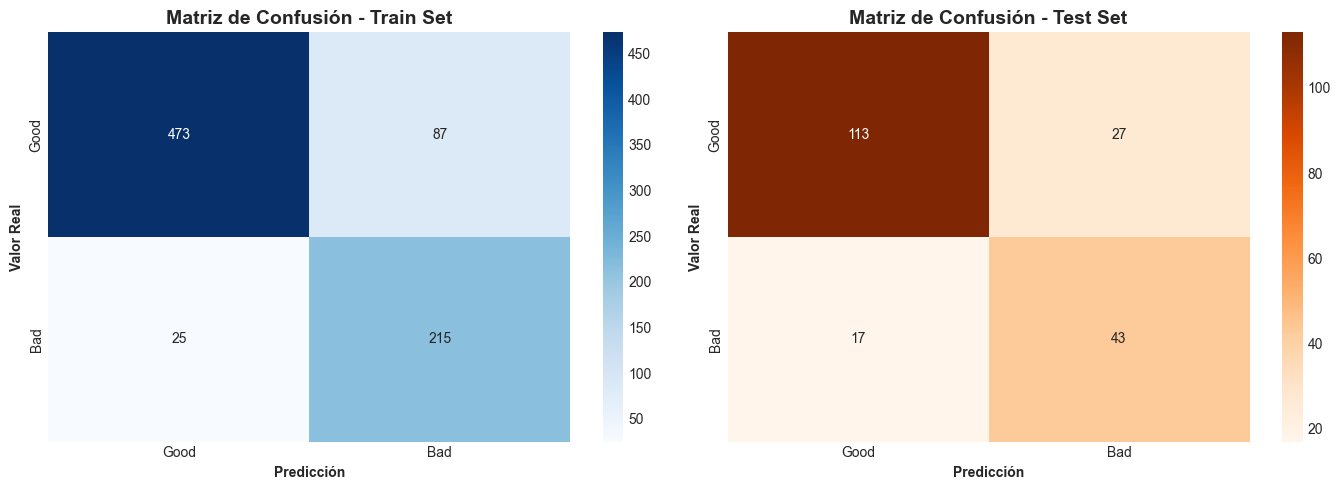


📊 Interpretación Matriz de Confusión (Test Set):
  - True Negatives (TN): 113 - Correctamente predijo 'Good'
  - False Positives (FP): 27 - Predijo 'Bad' pero era 'Good' ❌
  - False Negatives (FN): 17 - Predijo 'Good' pero era 'Bad' ❌
  - True Positives (TP): 43 - Correctamente predijo 'Bad'

💡 Contexto del negocio:
  - FP (Tipo I): Rechazar buen cliente → Oportunidad perdida
  - FN (Tipo II): Aprobar mal cliente → Pérdida de dinero


In [45]:
# Matriz de Confusión
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train Set
cm_train = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
axes[0].set_title('Matriz de Confusión - Train Set', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Valor Real', fontweight='bold')
axes[0].set_xlabel('Predicción', fontweight='bold')

# Test Set
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
axes[1].set_title('Matriz de Confusión - Test Set', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Valor Real', fontweight='bold')
axes[1].set_xlabel('Predicción', fontweight='bold')

plt.tight_layout()
plt.show()

# Interpretación de la matriz
tn, fp, fn, tp = cm_test.ravel()
print("\n📊 Interpretación Matriz de Confusión (Test Set):")
print(f"  - True Negatives (TN): {tn} - Correctamente predijo 'Good'")
print(f"  - False Positives (FP): {fp} - Predijo 'Bad' pero era 'Good' ❌")
print(f"  - False Negatives (FN): {fn} - Predijo 'Good' pero era 'Bad' ❌")
print(f"  - True Positives (TP): {tp} - Correctamente predijo 'Bad'")

print(f"\n💡 Contexto del negocio:")
print(f"  - FP (Tipo I): Rechazar buen cliente → Oportunidad perdida")
print(f"  - FN (Tipo II): Aprobar mal cliente → Pérdida de dinero")


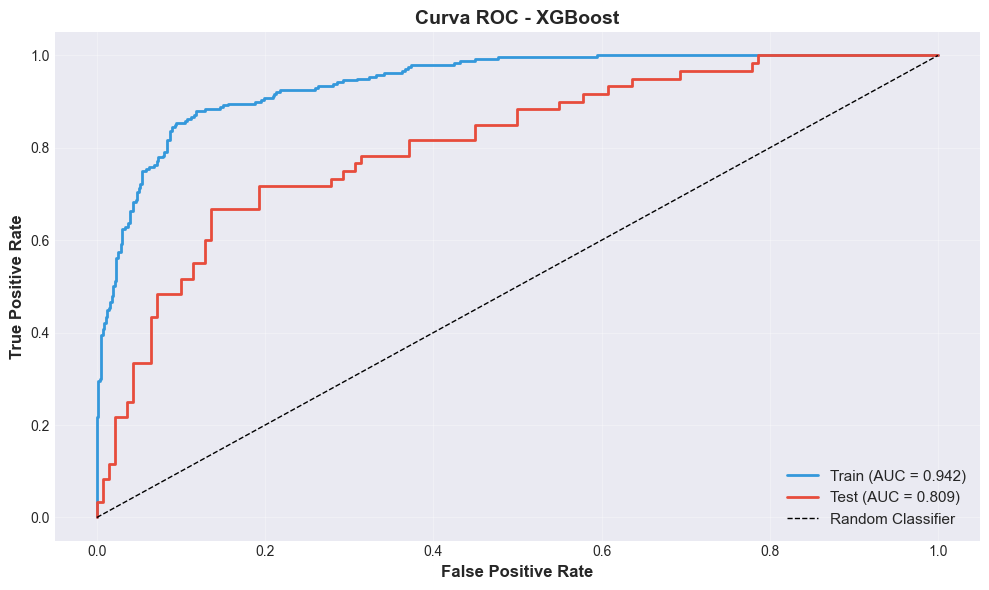

💡 Interpretación ROC-AUC:
  - AUC = 1.0: Clasificador perfecto
  - AUC = 0.5: Random classifier (línea diagonal)
  - Nuestro modelo: 0.809


In [46]:
# Curva ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {roc_auc_score(y_train, y_pred_proba_train):.3f})', 
         linewidth=2, color='#3498db')
plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {roc_auc_score(y_test, y_pred_proba_test):.3f})', 
         linewidth=2, color='#e74c3c')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('Curva ROC - XGBoost', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("💡 Interpretación ROC-AUC:")
print("  - AUC = 1.0: Clasificador perfecto")
print("  - AUC = 0.5: Random classifier (línea diagonal)")
print(f"  - Nuestro modelo: {roc_auc_score(y_test, y_pred_proba_test):.3f}")

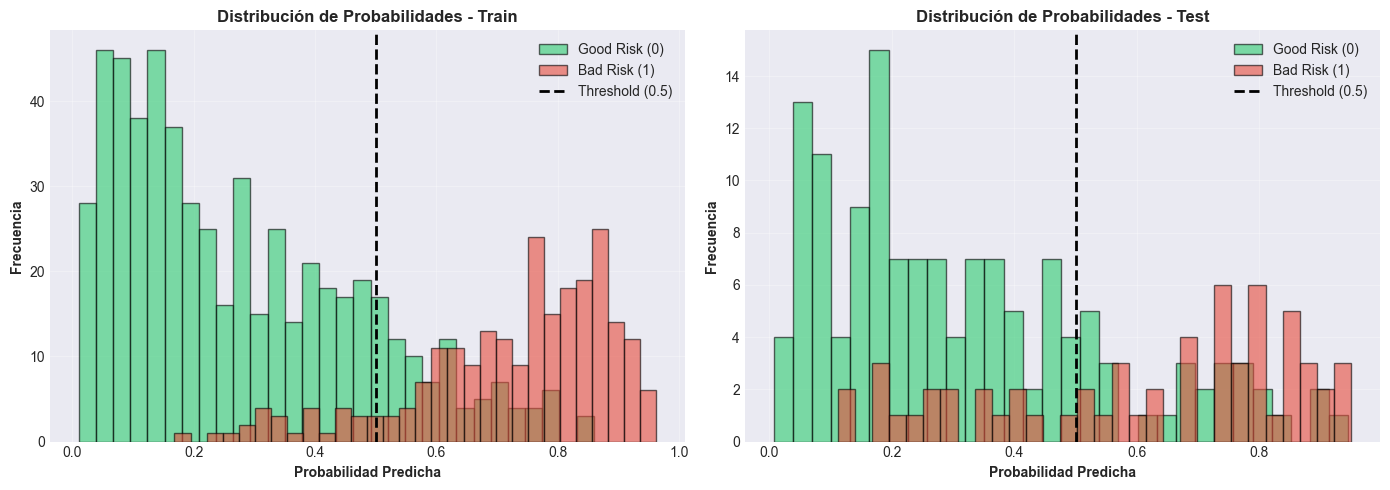


💡 Interpretación:
  - Separación clara entre clases → Modelo discrimina bien
  - Solapamiento → Clases difíciles de separar


In [47]:
# Distribución de probabilidades predichas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train
axes[0].hist(y_pred_proba_train[y_train == 0], bins=30, alpha=0.6, 
            label='Good Risk (0)', color='#2ecc71', edgecolor='black')
axes[0].hist(y_pred_proba_train[y_train == 1], bins=30, alpha=0.6, 
            label='Bad Risk (1)', color='#e74c3c', edgecolor='black')
axes[0].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[0].set_xlabel('Probabilidad Predicha', fontweight='bold')
axes[0].set_ylabel('Frecuencia', fontweight='bold')
axes[0].set_title('Distribución de Probabilidades - Train', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test
axes[1].hist(y_pred_proba_test[y_test == 0], bins=30, alpha=0.6, 
            label='Good Risk (0)', color='#2ecc71', edgecolor='black')
axes[1].hist(y_pred_proba_test[y_test == 1], bins=30, alpha=0.6, 
            label='Bad Risk (1)', color='#e74c3c', edgecolor='black')
axes[1].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[1].set_xlabel('Probabilidad Predicha', fontweight='bold')
axes[1].set_ylabel('Frecuencia', fontweight='bold')
axes[1].set_title('Distribución de Probabilidades - Test', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Interpretación:")
print("  - Separación clara entre clases → Modelo discrimina bien")
print("  - Solapamiento → Clases difíciles de separar")

# ## 8. Feature Importance

In [48]:
# Obtener importancia de features
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("="*60)
print("🔍 FEATURE IMPORTANCE - TOP 10")
print("="*60)
print(feature_importance.head(10).to_string(index=False))

🔍 FEATURE IMPORTANCE - TOP 10
            feature  importance
    checking_status    0.194410
 property_magnitude    0.067393
     savings_status    0.066304
other_payment_plans    0.062187
     credit_history    0.061148
           duration    0.052625
         employment    0.049692
      own_telephone    0.048168
    residence_since    0.045642
   existing_credits    0.042413


In [ ]:
# Visualización de Feature Importance
plt.figure(figsize=(10, 8))
top_n = 15
top_features = feature_importance.head(top_n)

plt.barh(range(top_n), top_features['importance'].values, color='#9b59b6')
plt.yticks(range(top_n), top_features['feature'].values)
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Features - XGBoost Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Nota: Esta es la importancia BÁSICA de XGBoost")
print("   En el próximo notebook usaremos SHAP para interpretabilidad avanzada")


# ## 9. Guardar Modelo y Artefactos

In [ ]:
# Crear carpeta para modelos si no existe
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

print("="*60)
print("💾 GUARDANDO MODELO Y ARTEFACTOS")
print("="*60)

# Guardar modelo
model_path = models_dir / 'xgboost_model.pkl'
joblib.dump(model, model_path)
print(f"✅ Modelo guardado: {model_path}")

# Guardar encoders
encoders_path = models_dir / 'label_encoders.pkl'
joblib.dump(label_encoders, encoders_path)
print(f"✅ Encoders guardados: {encoders_path}")

# Guardar nombres de features (para referencia)
feature_names_path = models_dir / 'feature_names.pkl'
joblib.dump(X_train.columns.tolist(), feature_names_path)
print(f"✅ Feature names guardados: {feature_names_path}")

# Guardar métricas
metrics_path = models_dir / 'model_metrics.csv'
metrics_df.to_csv(metrics_path, index=False)
print(f"✅ Métricas guardadas: {metrics_path}")


In [ ]:
# Verificar que se puede cargar correctamente
print("\n🔍 Verificando carga del modelo...")

loaded_model = joblib.load(model_path)
loaded_encoders = joblib.load(encoders_path)

# Hacer una predicción de prueba
test_prediction = loaded_model.predict(X_test[:5])
print(f"✅ Modelo cargado y funcional")
print(f"   Predicciones de prueba: {test_prediction}")


# ## 10. Resumen y Conclusiones

In [ ]:
print("="*60)
print("📝 RESUMEN EJECUTIVO - MODELADO")
print("="*60)

print(f"""
✅ MODELO ENTRENADO EXITOSAMENTE
   - Algoritmo: XGBoost Classifier
   - Features: {X_train.shape[1]}
   - Training samples: {X_train.shape[0]}
   - Test samples: {X_test.shape[0]}
   
📊 PERFORMANCE EN TEST SET
   - Accuracy: {test_acc:.3f} {'✅' if test_acc > 0.75 else '❌'}
   - Precision: {metrics_df.loc[1, 'Precision']:.3f}
   - Recall: {metrics_df.loc[1, 'Recall']:.3f}
   - F1-Score: {metrics_df.loc[1, 'F1-Score']:.3f}
   - ROC-AUC: {metrics_df.loc[1, 'ROC-AUC']:.3f}
   
🔝 TOP 3 FEATURES MÁS IMPORTANTES
   1. {feature_importance.iloc[0]['feature']}: {feature_importance.iloc[0]['importance']:.4f}
   2. {feature_importance.iloc[1]['feature']}: {feature_importance.iloc[1]['importance']:.4f}
   3. {feature_importance.iloc[2]['feature']}: {feature_importance.iloc[2]['importance']:.4f}
   
⚖️ MANEJO DE DESBALANCEO
   - scale_pos_weight: {scale_pos_weight:.2f}
   - Estrategia efectiva: {'✅ Sí' if abs(metrics_df.loc[1, 'Precision'] - metrics_df.loc[1, 'Recall']) < 0.1 else '⚠️ Revisar'}
   
💾 ARTEFACTOS GUARDADOS
   - Modelo: xgboost_model.pkl
   - Encoders: label_encoders.pkl
   - Features: feature_names.pkl
   - Métricas: model_metrics.csv
   
🎯 PRÓXIMOS PASOS
   1. Implementar SHAP para interpretabilidad avanzada
   2. Analizar explicaciones individuales (waterfall plots)
   3. Identificar patrones globales (summary plots)
   4. Crear dashboard interactivo
""")

print("✅ Modelado completado exitosamente")
print("📁 Listo para siguiente fase: Interpretabilidad con SHAP")